In [28]:
# Imports & Setup

import sys
import warnings

import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

PROJECT_FOLDER = '/home/ricardo/coding/data-science/projects/predict_value_change_from_fm_data/'

sys.path.insert(0, PROJECT_FOLDER)

from utils import POSITION_MAPPING, FOOTEDNESS_MAPPING, name_to_id, name_char_replacer

plt.rcParams["figure.figsize"] = (20,10)

warnings.filterwarnings('ignore')

In [29]:
# Import datasets

fm20_dataset = pd.read_csv(PROJECT_FOLDER + "datasets/datafm20.csv")
transfermarkt_players_dataset = pd.read_csv(PROJECT_FOLDER + "datasets/players.csv")
transfermarkt_valuations_dataset = pd.read_csv(PROJECT_FOLDER + "datasets/player_valuations.csv")

In [30]:
# Prepare dataset - merge fm20_df and less_28_players

# Use only players with less than 28 yo

transfermarkt_base_players_df = transfermarkt_players_dataset.query("last_season >= 2021 & date_of_birth >= '1992-01-01' & position != 'Goalkeeper'")
transfermarkt_base_players_df.sort_values(by='market_value_in_gbp', ascending=False, inplace=True)

fm20_base_players_df = fm20_dataset.query("Age <= 27 & `Best Pos` != 'GK'")
fm20_base_players_df.sort_values(by='Value', ascending=False, inplace=True)

In [31]:
# Map country_of_citizenship (Transfermarkt) to country codes (FM20)

fm20_name_nation_mapping = fm20_dataset.groupby('Nation').head()[['Name', 'Nation']]
fm20_name_nation_mapping['Transfermarkt_Name'] = fm20_name_nation_mapping['Name'].apply(name_to_id).apply(lambda x: x.replace('-scaron-', 's'))

transfermarkt_name_nation_mapping = transfermarkt_base_players_df[['name', 'country_of_citizenship']]

player_nationalities_mapping = fm20_name_nation_mapping.merge(transfermarkt_name_nation_mapping, left_on='Transfermarkt_Name', right_on='name')
player_nationalities_mapping.drop_duplicates(subset='Nation', inplace=True)

fm20_base_players_df = fm20_base_players_df.merge(player_nationalities_mapping[['Nation', 'country_of_citizenship']], on='Nation')

In [32]:
# Map position (Transfermarkt) to Best Pos (FM20)


transfermarkt_base_players_df['FM_Pos'] = transfermarkt_base_players_df['position'].apply(lambda x: x[0])

fm20_base_players_df['Transfermarkt_Pos'] = fm20_base_players_df['Best Pos'].map(POSITION_MAPPING)

In [33]:
# Map name (Transfermarkt) to Name (FM20)

fm20_base_players_df['Transfermarkt_Name'] = fm20_base_players_df['Name'].apply(name_char_replacer).apply(name_to_id)

In [34]:
# Merge dataframes

transfermarkt_fm20_merged_df = fm20_base_players_df.merge(transfermarkt_base_players_df, left_on=['Transfermarkt_Name', 'country_of_citizenship', 'Transfermarkt_Pos'], right_on=['name', 'country_of_citizenship', 'FM_Pos'])

transfermarkt_fm20_merged_df.drop_duplicates(subset=['Transfermarkt_Name', 'country_of_citizenship', 'FM_Pos'], inplace=True)

In [35]:
# Insert target values (valuation now vs valuations 2020)

transfermarkt_fm20_merged_df['value_2022'] = transfermarkt_fm20_merged_df['market_value_in_gbp']

player_values_2020 = transfermarkt_valuations_dataset.query("date >= '2019-07-01' & date <= '2020-12-31'").sort_values(by='date', ascending=True).drop_duplicates(subset='player_id')

player_values_2020['value_2020'] = player_values_2020['market_value']

players_with_values = transfermarkt_fm20_merged_df.merge(player_values_2020, on='player_id')

players_with_values['value_diff'] = (players_with_values['value_2022'] - players_with_values['value_2020'])

<AxesSubplot:>

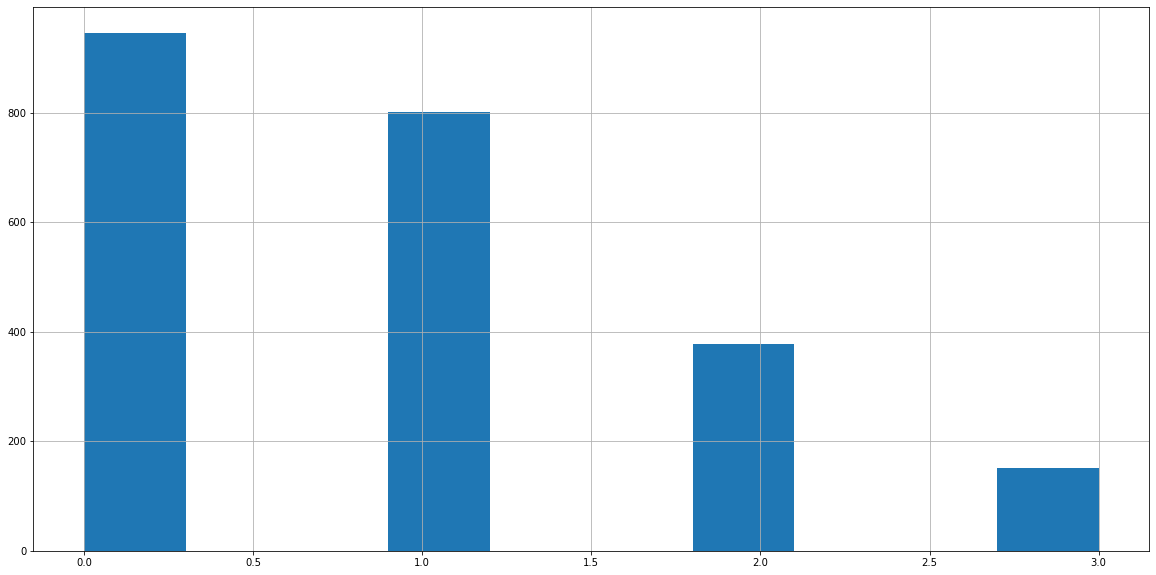

In [36]:
# Prepare df for stratify

value_bins = [-np.inf, 0, 2000000, 10000000, np.inf]

players_with_values['value_cat'] = pd.cut(players_with_values["value_diff"], bins=value_bins, labels=range(len(value_bins)-1))

players_with_values['value_cat'].hist()

In [37]:
# Create test set

from sklearn.model_selection import train_test_split

players_for_analysis = players_with_values[:]

players_for_analysis.dropna(subset=['value_diff'], inplace=True)

x_train, x_test, y_train, y_test = train_test_split(players_for_analysis, players_for_analysis['value_diff'], test_size=0.2, random_state=42, stratify=players_for_analysis['value_cat'])

In [38]:
# Revert to clean training set

players_v1 = x_train.drop(['value_diff', 'value_cat'], axis=1)
players_labels_v1 = x_train['value_diff'].copy()

In [39]:
# Custom Nation transformer

from sklearn.base import BaseEstimator, TransformerMixin

class NationToRank(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        fifa_wr = pd.read_csv(PROJECT_FOLDER + "datasets/fifa_ranking-2021-05-27.csv")
        nation_encoder = fifa_wr.query('rank_date == "2020-10-22"')[['rank', 'country_abrv']]
        max_rank = nation_encoder['rank'].max() + 1
        X['Nation_rank'] = 1 - (X['Nation'].map(nation_encoder.set_index('country_abrv')['rank']).fillna(max_rank) / max_rank)
        X.drop('Nation', axis=1, inplace=True)
        return X

In [40]:
# Custom Attributes transformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from utils import apply_mean_attribute_list, PLAYER_ATTR

class AttributeMerger(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        physical_attr = ['Acc', 'Pac', 'Sta', 'Str', 'Agi', 'Bal', 'Jum', 'Nat']
        mental_attr = ['Wor', 'Vis', 'Tea', 'Pos', 'OtB', 'Ldr', 'Fla', 'Det', 'Dec', 'Cnt', 'Cmp', 'Bra', 'Ant', 'Agg']
        apply_mean_attribute_list(X, 'M+P', physical_attr + mental_attr)
        X['M+P'] = X['M+P'] / 20
        X.drop(PLAYER_ATTR, axis=1, inplace=True)
        return X


In [41]:
# Custom Based transformer

from sklearn.base import BaseEstimator, TransformerMixin

class BasedToRank(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        based_encoder = players_with_values.groupby('Based').sum().rank(ascending=True, method='first')
        max_rank = based_encoder['value_2020'].max()
        X['Based_rank'] = (X['Based'].map(based_encoder['value_2020']).fillna(max_rank) / max_rank)
        X.drop('Based', axis=1, inplace=True)
        return X

In [42]:
# Custom Foot transformer

from sklearn.base import BaseEstimator, TransformerMixin

class FootToRank(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Foot_rank'] = X['Preferred Foot'].map(FOOTEDNESS_MAPPING)
        X.drop('Preferred Foot', axis=1, inplace=True)
        return X

In [43]:
# Using transformation pipelines

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from utils import PLAYER_ATTR

players = x_train.drop('Value', axis=1)

features_v1 = {
    'att': (PLAYER_ATTR, ['M+P']),
    'num': (PLAYER_ATTR + ['Age'], None),
    # 'foo': (['Preferred Foot'], None),
    # 'pos': (['Best Pos'], None),
    'nat': (['Nation'], None),
    'bas': (['Based'], None)
}

feature_labels_v1 = list(np.concatenate([f[1] if f[1] is not None else f[0] for k, f in features_v1.items()]).flat)

full_pipeline_v1 = ColumnTransformer([
    ("att", AttributeMerger(), features_v1['att'][0]),
    ("num", StandardScaler(), features_v1['num'][0]),
    # ("foo", FootToRank(), features_v1['foo'][0]),
    # ("pos", OneHotEncoder(), features_v1['pos'][0]),
    ("nat", NationToRank(), features_v1['nat'][0]),
    ("bas", BasedToRank(), features_v1['bas'][0])
])

players_prepared_v1 = full_pipeline_v1.fit_transform(players)

In [45]:
# Hyperparameter tuning

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

total_value_without_model = x_train['value_diff'].sum()

def predictor_performance(estimator, X, y):
    y_pred = estimator.predict(X)
    values = x_train[['value_diff']]
    values['pred'] = y_pred
    values.dropna(inplace=True)

    total_value_without_model = values['value_diff'].sum()
    total_value_with_model = values.query('pred == 1')['value_diff'].sum()

    score = total_value_with_model / total_value_without_model
    return score

rf_param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
}

value_predictor_v1 = RandomForestRegressor()
value_predictor_v1_grid_search = RandomizedSearchCV(value_predictor_v1, rf_param_grid, cv=5, scoring="neg_mean_absolute_error", return_train_score=True, n_iter=10, error_score="raise")

value_predictor_v1_grid_search.fit(players_prepared_v1, players_labels_v1)

(value_predictor_v1_grid_search.best_params_, value_predictor_v1_grid_search.best_score_)

({'n_estimators': 500, 'max_depth': 10}, -4009074.3948831772)

In [46]:
# Select and train model
## RandomForestClassifier

value_predictor_v1 = value_predictor_v1_grid_search.best_estimator_

value_predictor_v1.fit(players_prepared_v1, players_labels_v1)

RandomForestRegressor(max_depth=10, n_estimators=500)

In [45]:
# Test best threshold

value_predictions_proba_v1 = value_predictor_v1.predict_proba(players_prepared_v1)

total_value_without_model = x_train['value_diff'].sum()
max_value_without_model = x_train.query('value_diff > 0')['value_diff'].sum()
max_performance = (max_value_without_model - total_value_without_model) / total_value_without_model

train_players = x_train[:]
train_players['prob_1'] = value_predictions_proba_v1[:, 1]

model_performance_max = 0
ideal_threshold = 0
total_value_with_model_max = 0

for i in range(100):
    threshold = i / 100
    train_players['pred'] = value_predictions_proba_v1[:, 1] > threshold
    total_value_with_model = train_players.query('pred == 1')['value_diff'].sum()
    model_performance = (total_value_with_model - total_value_without_model) / total_value_without_model
    if model_performance > model_performance_max:
        model_performance_max = model_performance
        ideal_threshold = threshold
        total_value_with_model_max = total_value_with_model

print("Perf:", model_performance_max)
print("Max Perf:", max_performance)
print("Thres:", ideal_threshold)


Perf: 0.04692213169425655
Max Perf: 0.21697035880276677
Thres: 0.52


<AxesSubplot:>

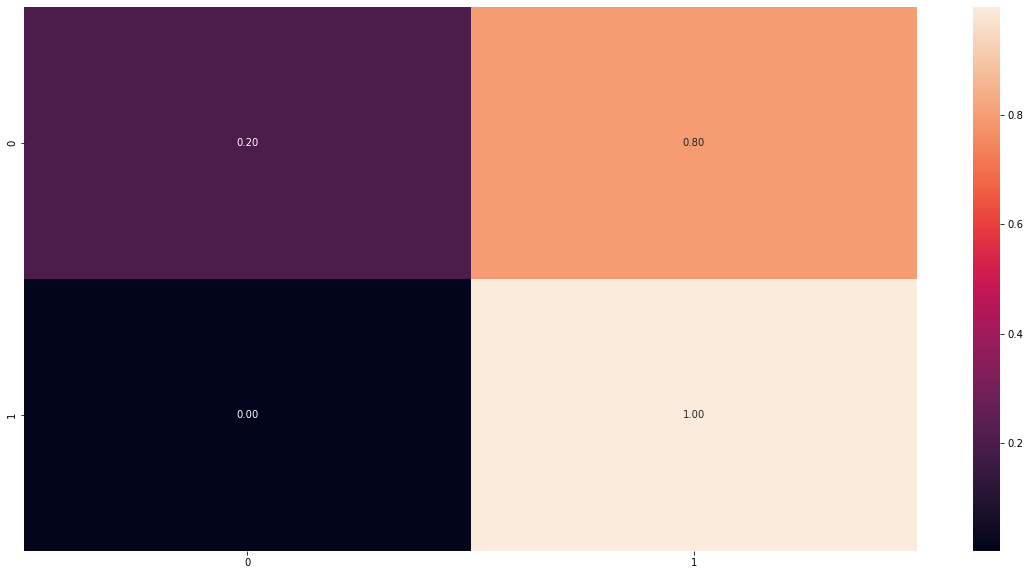

In [46]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(players_labels_v1, value_predictions_proba_v1[:, 1] > ideal_threshold)
conf_mx = conf_mx.astype('float') / conf_mx.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mx, annot=True, fmt='.2f')

<BarContainer object of 40 artists>

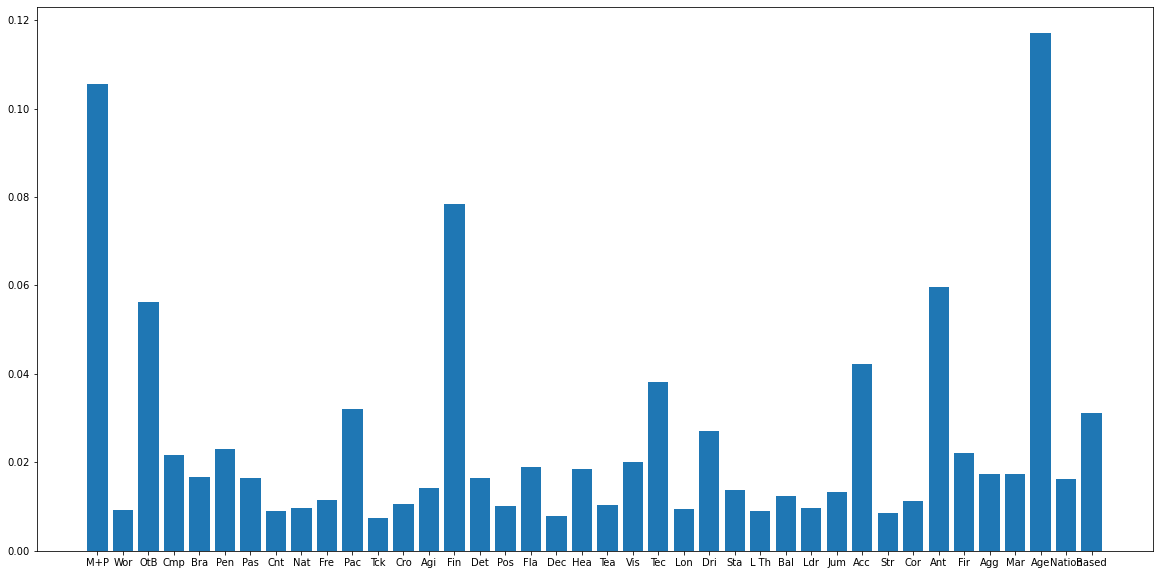

In [47]:
plt.bar(feature_labels_v1, value_predictor_v1.feature_importances_)

In [48]:
# Prepare test values for analysis

test_players_prepared = full_pipeline_v1.fit_transform(x_test)
test_players_labels = y_test

<AxesSubplot:>

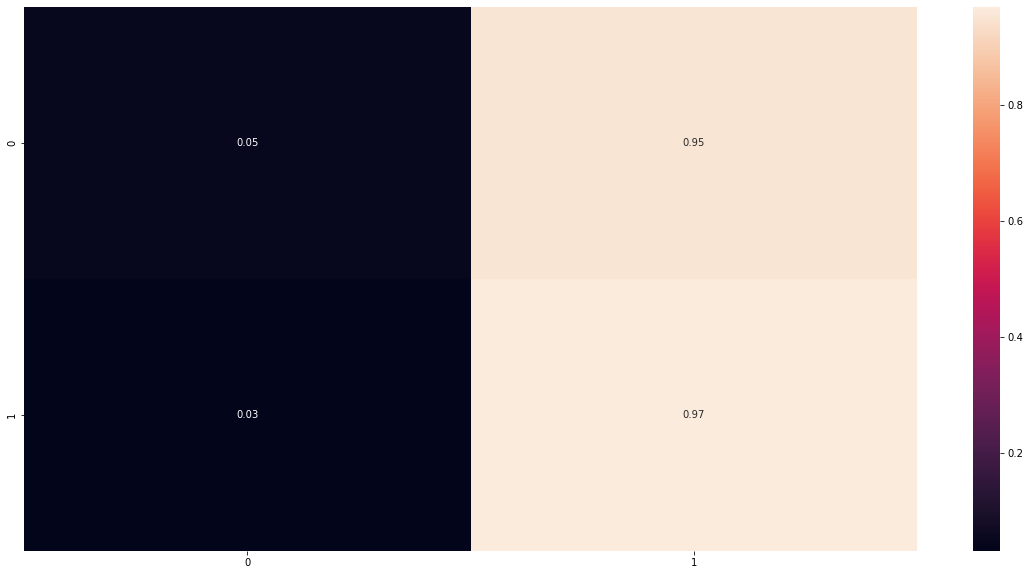

In [49]:
# Test values confusion matrix

test_value_predictions_proba_v1 = value_predictor_v1.predict_proba(test_players_prepared)

conf_mx = confusion_matrix(test_players_labels, test_value_predictions_proba_v1[:, 1] > ideal_threshold)
conf_mx = conf_mx.astype('float') / conf_mx.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mx, annot=True, fmt='.2f')

In [51]:
# Try with test model

test_value_predictions = value_predictor_v1.predict(test_players_prepared)

test_players_v1 = x_test[['Name', 'Age', 'Position', 'Club', 'PA', 'value_diff']]
test_players_v1['pred'] = test_value_predictions

# test_total_value_without_model = test_players_v1['value_diff'].sum()
# test_total_value_with_model = test_players_v1.query('pred == 1')['value_diff'].sum()
# test_max_value_without_model = test_players_v1.query('value_diff > 0')['value_diff'].sum()

# test_performance = (test_total_value_with_model - test_total_value_without_model) / test_total_value_without_model
# max_test_performance = (test_max_value_without_model - test_total_value_without_model) / test_total_value_without_model

# print("Perf:", test_performance)
# print("Max Perf:", max_test_performance)
# print("Value diff from max:", test_max_value_without_model - test_total_value_with_model)

In [51]:
# Test with player not in test or train

player_ids_in_model = players_for_analysis["Unnamed: 0"].values
players_not_in_model = fm20_dataset.query('`Unnamed: 0` not in @player_ids_in_model & `Best Pos` != "GK" & Age < 23 & CA > 100 & PA < 140')
players_not_in_model_prepared = full_pipeline_v1.transform(players_not_in_model)

players_not_in_model_predictions = value_predictor_v1.predict_proba(players_not_in_model_prepared)

players_not_in_model['pred'] = players_not_in_model_predictions[:, 1] > ideal_threshold

In [52]:
# Most players who were not fed into the model are because of name mismatches due to the latin/iso conversion
# So, next step would be to feed more players into the model by improving the conversion and see if the model improves